In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter
import random

Load dataset from google drive

In [24]:
dataset_path = "/content/drive/MyDrive/dataset/animals/animals"
animals = os.listdir(dataset_path)
print(animals)

['cats', 'dogs', 'panda']


**Image Selection**

In [25]:
selected_images = {}
for animal in animals:
  animal_path = os.path.join(dataset_path, animal)
  images = os.listdir(animal_path)
  if len(images) >= 3000:
    selected_images[animal] = random.sample(images, 3000)
  else:
    print(f"Class {animal} Selecting all {len(images)} images.")
    selected_images[animal] = images

Class cats Selecting all 1000 images.
Class dogs Selecting all 1000 images.
Class panda Selecting all 1000 images.


**Parameters**

In [26]:
image_size = 32
images_count = 200
k_values = list(range(2, 20))

**Image Preprocessing**

In [27]:
train_imgs = []

for index, animal in enumerate(animals):
    label = index
    path = os.path.join(dataset_path, animal)
    images = os.listdir(path)
    random.shuffle(images)

    for img in images[:images_count]:
        img_path = os.path.join(path, img)
        img_bgr = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (image_size, image_size))
        train_imgs.append([img_gray, label])

np.random.shuffle(train_imgs)

**Display Sample Image**

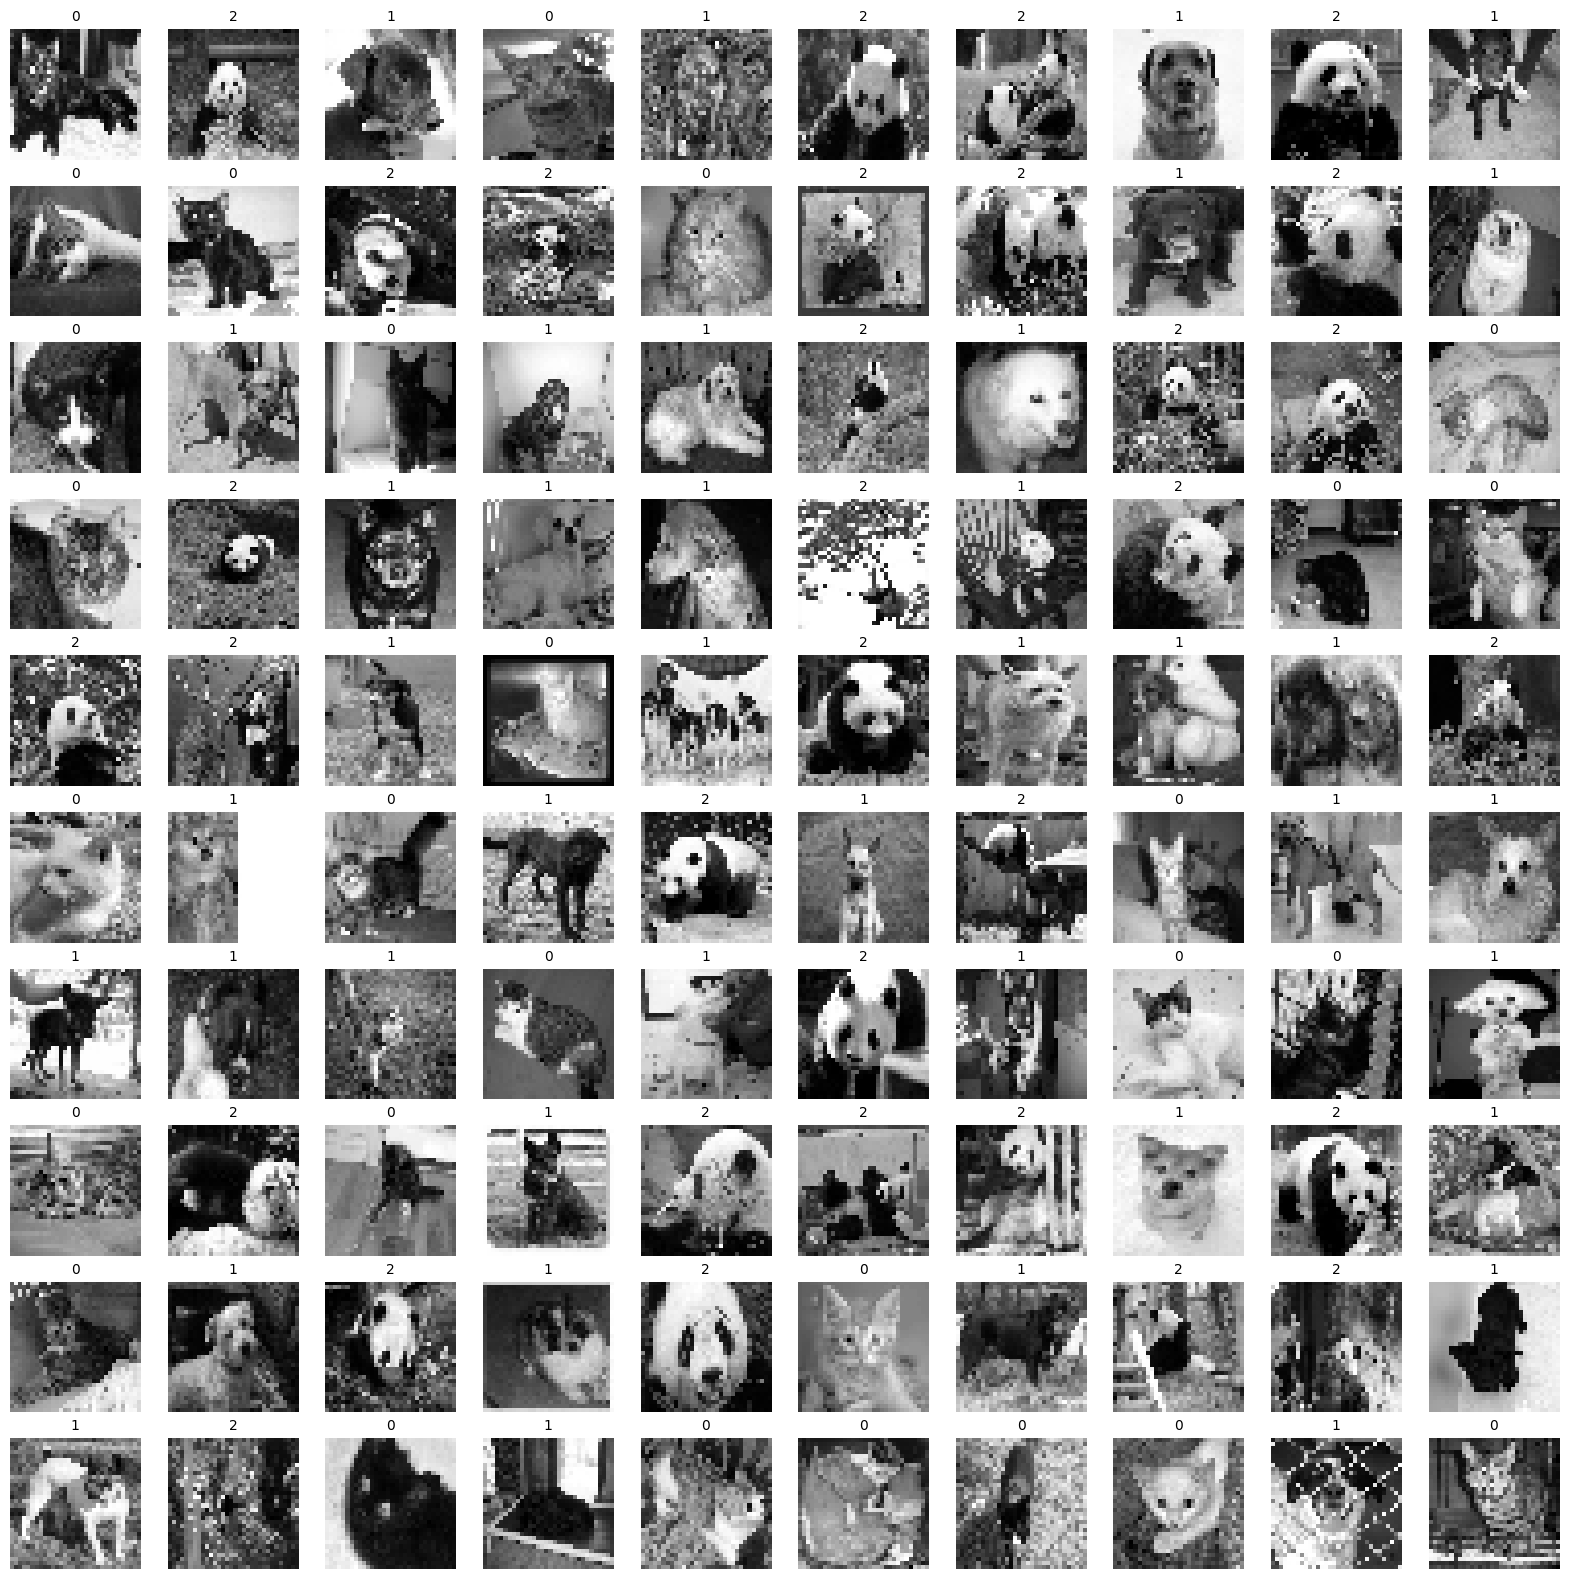

In [28]:
rows, cols = 10, 10
plt.figure(figsize=(20, 20))

for i in range(rows * cols):
    img, label = train_imgs[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.show()

**Distance Function**

In [29]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

**Cross Validation**

In [31]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

**Model Evaluating**

In [32]:
X = np.array([img[0].flatten() for img in train_imgs])
Y = np.array([img[1] for img in train_imgs])

avg_l1, avg_l2 = cross_validation(X, Y, k_values)

for k in k_values:
    print(f"Average Accuracy for k={k} (L1): {avg_l1[k]:.2f}")
    print(f"Average Accuracy for k={k} (L2): {avg_l2[k]:.2f}")

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
Average Accuracy for k=2 (L1): 0.35
Average Accuracy for k=2 (L2): 0.38
Average Accuracy for k=3 (L1): 0.38
Average Accuracy for k=3 (L2): 0.42
Average Accuracy for k=4 (L1): 0.35
Average Accuracy for k=4 (L2): 0.43
Average Accuracy for k=5 (L1): 0.36
Average Accuracy for k=5 (L2): 0.42
Average Accuracy for k=6 (L1): 0.37
Average Accuracy for k=6 (L2): 0.42
Average Accuracy for k=7 (L1): 0.36
Average Accuracy for k=7 (L2): 0.42
Average Accuracy for k=8 (L1): 0.35
Average Accuracy for k=8 (L2): 0.42
Average Accuracy for k=9 (L1): 0.38
Average Accuracy for k=9 (L2): 0.43
Average Accuracy for k=10 (L1): 0.37
Average Accuracy for k=10 (L2): 0.43
Average Accuracy for k=11 (L1): 0.37
Average Accuracy for k=11 (L2): 0.43
Average Accuracy for k=12 (L1): 0.36
Average Accuracy for k=12 (L2): 0.43
Average Accuracy for k=13 (L1): 0.38
Average Accuracy for k=13 (L2): 0.46
Average Accuracy for k=14 (L1): 0.37
A

Accuracy vs KNN values

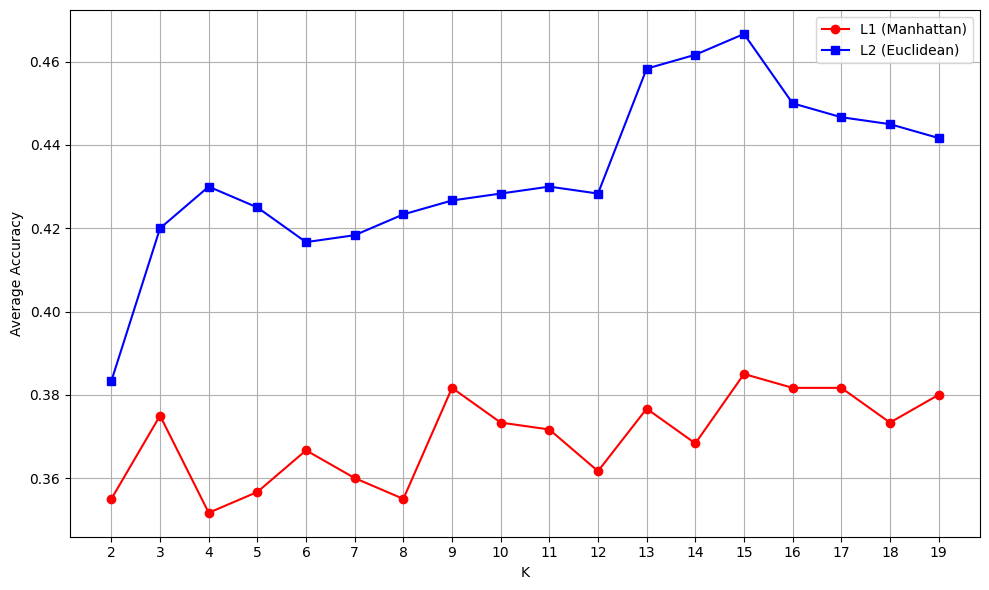

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='red')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='blue')

plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(k_values)  # Ensure integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Top 5 Prediction

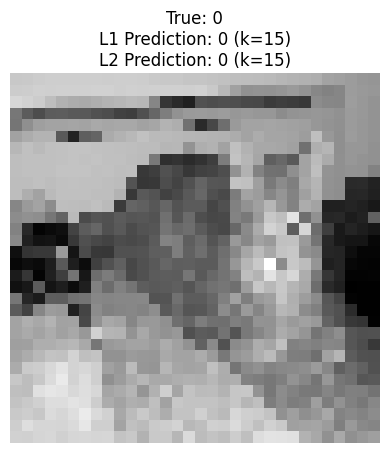

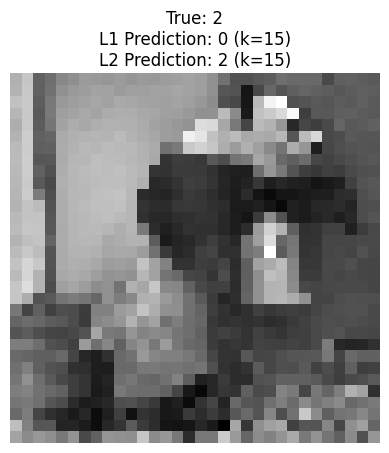

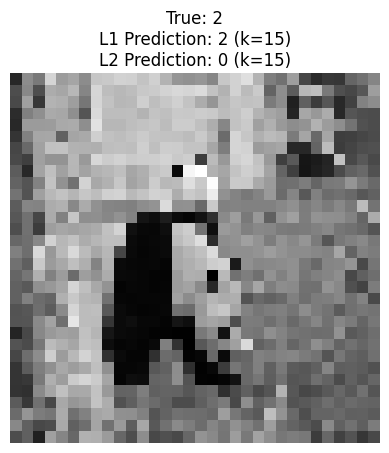

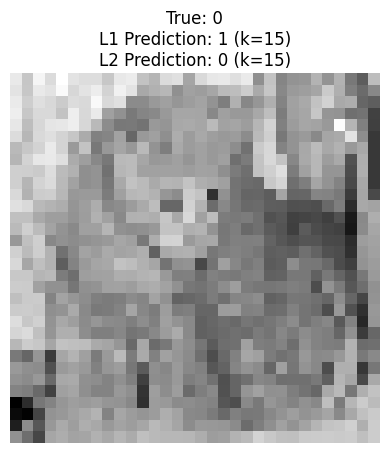

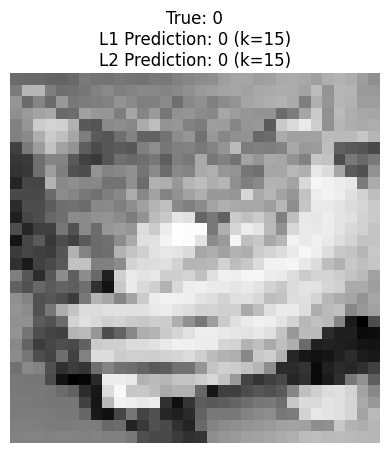

In [35]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = Y[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, Y, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, Y, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {true_label}\n"
        f"L1 Prediction: {pred_l1} (k={best_k_l1})\n"
        f"L2 Prediction: {pred_l2} (k={best_k_l2})"
    )
    plt.show()